## Apply time series for forecasting on number of students in metro east over time 

In [54]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm
import plotly.express as px
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

In [55]:
# load data
enrollment_ts = pd.read_excel('eda/data/enrollment data.xlsx', sheet_name='Clean_PO_Detail')

In [56]:
# variable to apply time series to
grade = 'GR12'
metro_name = 'METRO EAST'

In [57]:
# group by district and circuit and sum the values together
metro_enrollment = enrollment_ts.groupby(['EDUC DISTRICT', 'YEAR']).agg([sum])
metro_enrollment = metro_enrollment[grade].reset_index()
metro_enrollment

,EDUC DISTRICT,YEAR,sum
0,CAPE WINELANDS,2000,5864
1,CAPE WINELANDS,2001,5900
2,CAPE WINELANDS,2002,6153
3,CAPE WINELANDS,2003,5872
4,CAPE WINELANDS,2004,5725
...,...,...,...
187,WEST COAST,2019,2602
188,WEST COAST,2020,2702
189,WEST COAST,2021,2866
190,WEST COAST,2022,3183


In [58]:
# create plotly plot of metro enrollments
fig = px.line(metro_enrollment, x='YEAR', y='sum', color='EDUC DISTRICT',
    labels={
        'sum': 'student enrollment',
        'YEAR': 'Year',
        'variable': 'Metro'
    },
title = 'Enrollment Time Series')
fig.show()

In [59]:
# method to subset data according to metro and variable to count for further analysis
def filter_df(df, metro, variable):
    
    metro_enrollment = df.groupby(['EDUC DISTRICT', 'YEAR']).agg([sum]) # group by education district
    metro_enrollment = metro_enrollment[str(variable)].reset_index()

    return metro_enrollment[metro_enrollment['EDUC DISTRICT'] == metro].rename(columns = {'sum':str(variable)})

enrollment_subset = filter_df(enrollment_ts, metro_name, grade)
enrollment_subset

,EDUC DISTRICT,YEAR,GR12
72,METRO EAST,2000,5574
73,METRO EAST,2001,5419
74,METRO EAST,2002,5623
75,METRO EAST,2003,5791
76,METRO EAST,2004,6053
77,METRO EAST,2005,6136
78,METRO EAST,2006,6197
79,METRO EAST,2007,6937
80,METRO EAST,2008,7114
81,METRO EAST,2009,7054


In [60]:
# method to make the data stationary
def subtract_from_previous(arr):
    if len(arr) == 0:
        return []

    return [arr[i] - arr[i - 1] for i in range(1, len(arr))]

[0.9975000694311603, 0.060123942823251925]

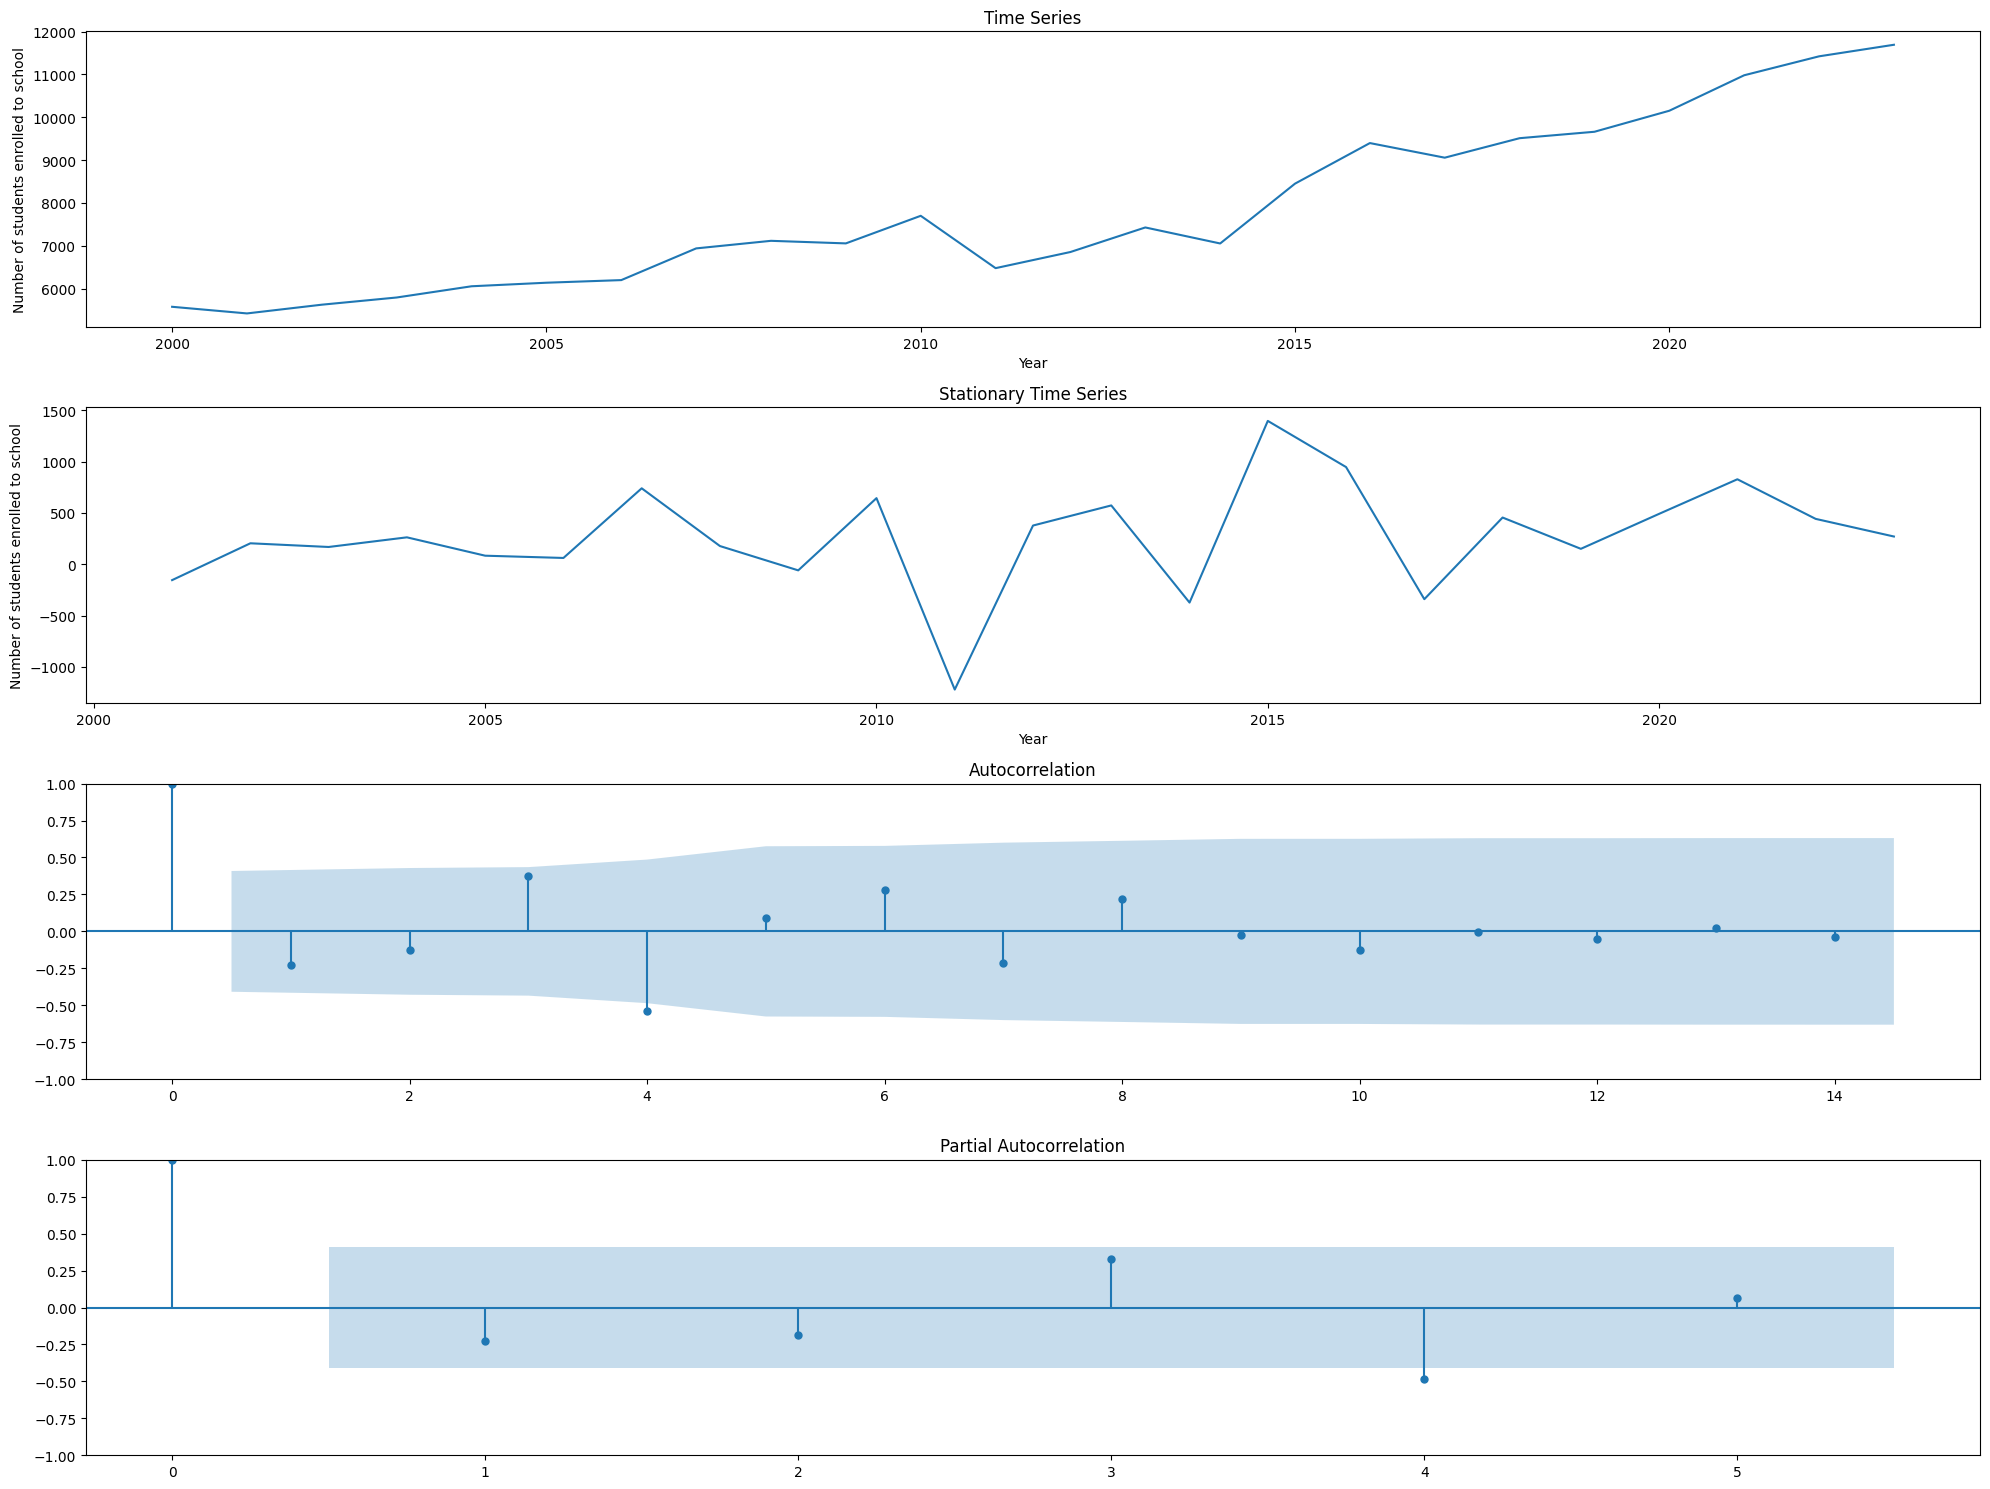

In [61]:
# This function plots time series of student enrollment for a given metro, circuit and grade
# If the time series is not stationary it is converted so that it is stationary and the stationary plot will be plotted
# the pacf and acf plots are also plotted
fig, axes = plt.subplots(4, 1, figsize=(20,15))

# def plot_learner_ts(metro, circuit, count_var):
def plot_learner_ts(df_subset):
    count_var = df_subset.iloc[:,[2]].columns.values[0]
    
    # do stationarity test (augmented Dickey-Fuller test)
    adf_val = adfuller(df_subset[str(count_var)])
    
    # if p val > 0.05 then time series is not stationary. If p value < 0.05 then it is stationary
    # if time series is stationary then convert to stationary plot
    if adf_val[1] > 0.05:
        # plot number of students over time
        axes[0].plot(df_subset['YEAR'], (df_subset[str(count_var)]))
        axes[0].set_title('Time Series')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Number of students enrolled to school')

        # convert time series to stationary time series
        transformed_ts = subtract_from_previous(np.array(df_subset[str(count_var)]))
        transformed_adf = adfuller(transformed_ts)

        axes[1].plot(df_subset['YEAR'][1:], transformed_ts) # time series for stationary plot
        axes[1].set_title('Stationary Time Series')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Number of students enrolled to school')

        # plot ACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        acf_plot = plot_acf(np.array(transformed_ts), ax=axes[2]) # acf for stationary plot

        # plot PACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        pacf_plot = plot_pacf(transformed_ts, lags=5, ax=axes[3]) # pacf for stationary plot
    
    # if the time series is already stationary then plot the time series, acf and pacf plots as is
    else:
        # plot number of students over time
        axes[0].plot(df_subset['YEAR'], (df_subset[str(count_var)]))
        axes[0].set_title('Time Series')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Number of students enrolled to school')

        # plot ACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        acf_plot = plot_acf(df_subset[str(count_var)], ax=axes[2])

        # plot PACF (see https://www.youtube.com/watch?v=y8opUEd05Dg&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=3)
        pacf_plot = plot_pacf(df_subset[str(count_var)], lags=2, ax=axes[3])

    # plot all graphs on same grid
    plt.tight_layout()

    # return transformed adf only if the transformation needed to happen
    if adf_val[1] > 0.05:
        return [adf_val[1], transformed_adf[1]]
    else:
        return adf_val[1]

plot_learner_ts(enrollment_subset)

In [62]:
# save actual values and forecasted values to a csv
def save_output(metro_name, grade, observations, predictions, years):
    data = {'observations': observations, 'predictions': predictions, 'year': years}
    preds_df = pd.DataFrame(data)
    preds_df.to_csv('output/'+metro_name+'_'+grade+'_predictions.csv', index=False)

    return "data saved"

In [74]:
# Make predictions on data with the ARIMA model using rolling forecast
a_metro_subset = enrollment_subset.copy() # to keep track of dataset in use for function in this block

X = a_metro_subset[grade].values

# Split data into test and train sets
size = int(len(X) * 0.2)
train, test = X[0:size], X[size:len(X)]

# keep track of outputs
history = [x for x in train] # rolling history
predictions = list() # keep track of predictions
preds_for_rmse = list() # keep track of predictions for rmse calculation
observations = list()

# rolling forecast
for t in range(len(test)+5):
 model = ARIMA(history, order=(1,2,0)) # run the arima model on train data
 model_fit = model.fit() # fit the model
 output = model_fit.forecast() # forecast next value
 yhat = output[0]
 predictions.append(yhat)
 
 # while model is running on known values
 if t < len(test):
    preds_for_rmse.append(yhat)
    obs = test[t]
    observations.append(obs)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
 
 # forecast predictions (2023 to 2028)
 else:
   history.append(yhat)
   observations.append(np.nan)
   print('predicted=%f' % (yhat))

rmse = sqrt(mean_squared_error(test, preds_for_rmse))
print('Test RMSE: %.3f' % rmse)


years = np.arange(2004,2029)
save_output(metro_name, grade, observations, predictions, years)


c:\Users\GEdwards\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

c:\Users\GEdwards\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



predicted=5897.264740, expected=6053.000000
predicted=6180.800998, expected=6136.000000
predicted=6305.281419, expected=6197.000000
predicted=6257.999993, expected=6937.000000


c:\Users\GEdwards\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



predicted=7086.933905, expected=7114.000000
predicted=7348.382415, expected=7054.000000
predicted=7278.624835, expected=7698.000000
predicted=7832.038979, expected=6476.000000
predicted=6591.440350, expected=6853.000000
predicted=6681.346796, expected=7426.000000
predicted=7564.611375, expected=7052.000000
predicted=7285.477931, expected=8449.000000
predicted=8399.135185, expected=9396.000000
predicted=9699.739873, expected=9055.000000
predicted=9377.990085, expected=9510.000000
predicted=9767.658638, expected=9660.000000
predicted=9942.405819, expected=10151.000000
predicted=10398.823404, expected=10979.000000
predicted=11225.413490, expected=11421.000000
predicted=11717.044450, expected=11691.000000
predicted=12001.166310
predicted=12305.553686
predicted=12609.227243
predicted=12911.772395
predicted=13213.373151
Test RMSE: 578.710


'data saved'

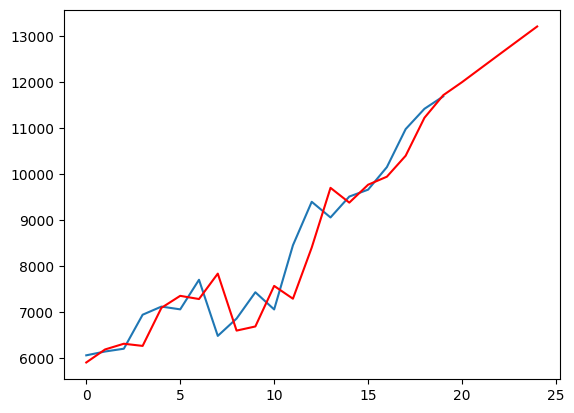

In [75]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()